# Cluster Pseudo-bulk Marker Genes

Try to find signal near certain marker genes for pseudo-bulk data across clusters.

In [ ]:
library(SnapATAC)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...


In [4]:
# Metadata file from previous run
metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')
metaData = metaData[order(metaData$sample_barcode), ]
head(metaData, 2)

,barcode,cluster,umap1,umap2,barcode.1,TN,UM,PP,UQ,CM,landmark,cluster.1,sample,sample_barcode
1206,AAACAACGACGATTAC,6,2.515876,8.252824,AAACAACGACGATTAC,42629,38455,38381,33575,51,0,6,D0,D0_AAACAACGACGATTAC
1207,AAACAACGACTCACGG,6,2.355841,7.403916,AAACAACGACTCACGG,4424,4009,3998,3694,4,0,6,D0,D0_AAACAACGACTCACGG


In [5]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [6]:
x.sp.list

$D0
number of barcodes: 11133
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9724
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8726
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10566
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 9895
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4105
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6334
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16287
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [7]:
bin.shared = Reduce(intersect, lapply(x.sp.list, function(x.sp) x.sp@feature$name));

In [8]:
# merge timepoints
x.sp.list <- lapply(x.sp.list, function(x.sp){
    idy = match(bin.shared, x.sp@feature$name);
    x.sp[,idy, mat="bmat"];
  })
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”

In [9]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [10]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap1", "umap2")])

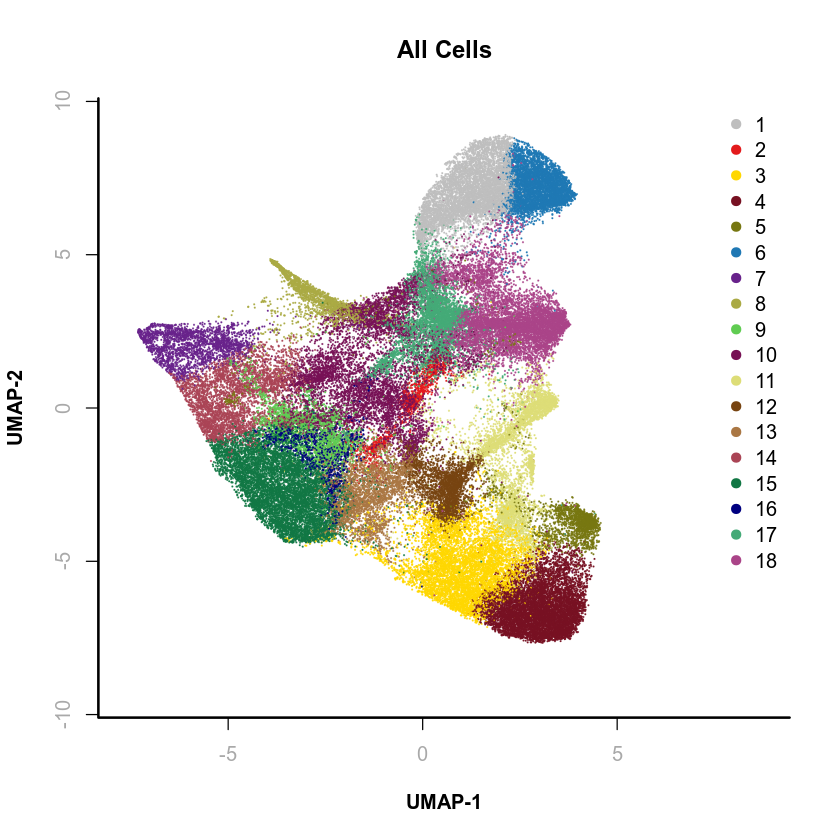

In [11]:
# verify all in order
plotViz(
    obj=x.sp,
    method="umap", 
    main="All Cells",
    point.color=x.sp@cluster, 
    point.size=0.1, 
    text.add= FALSE,
    down.sample=NULL,
    legend.add=TRUE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );

In [653]:
library(RColorBrewer)

In [654]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

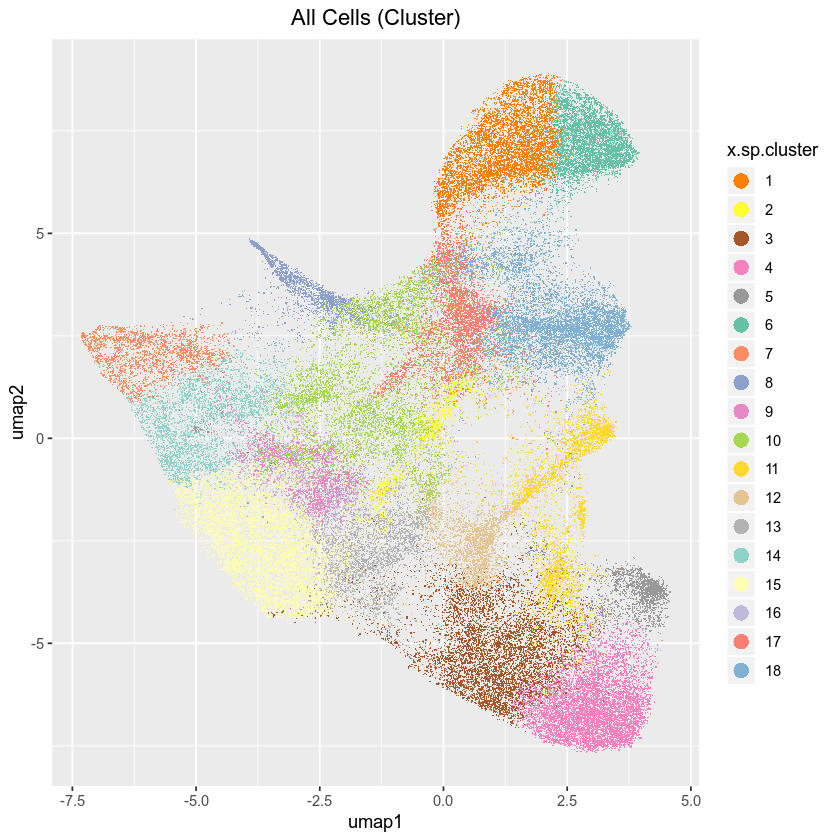

In [659]:
df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap1, y=umap2, col=x.sp.cluster)) +
geom_point(shape=".", size=2, alpha=1) +
scale_colour_manual(values = col_vector[seq(50,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Load Cluster Pseudo-bulk matrix

In [13]:
cts <- read.csv("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/cluster_bulk_peakset_matrix/cluster.bulk.overlap.cluster.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = gsub("chr", "", cts$chrom)
intervals_gr = makeGRangesFromDataFrame(cts)
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)
intervals_gr

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
chr1 16147 16347,54,19,12,30,4,16,2,6,34,13,18,4,28,17,42,6,16,20
chr1 51459 51659,1,0,3,2,0,0,0,0,0,2,0,0,3,2,0,0,0,1


[1] 467339     18

GRanges object with 467339 ranges and 0 metadata columns:
                           seqnames            ranges strand
                              <Rle>         <IRanges>  <Rle>
        chr1\t16147\t16347        1       16147-16347      *
        chr1\t51459\t51659        1       51459-51659      *
        chr1\t51689\t52109        1       51689-52109      *
      chr1\t180686\t181260        1     180686-181260      *
      chr1\t181268\t181597        1     181268-181597      *
                       ...      ...               ...    ...
  chrY\t25399202\t25399408        Y 25399202-25399408      *
  chrY\t26670497\t26671505        Y 26670497-26671505      *
  chrY\t56728041\t56728241        Y 56728041-56728241      *
  chrY\t56734685\t56734895        Y 56734685-56734895      *
  chrY\t56836760\t56836960        Y 56836760-56836960      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [14]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

## Gene Annotations

In [ ]:
library(EnsDb.Hsapiens.v86)

In [16]:
edb <- EnsDb.Hsapiens.v86

In [17]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [ ]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 0)

In [19]:
head(prom.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames        ranges strand |   gene_name         gene_id
                     <Rle>     <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1   67091-69090      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1 180393-182392      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [20]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

## Make Gene x Cluster matrix

### Promoters Only

In [21]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 26514 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           4
      [2]         2           5
      [3]         6          59
      [4]         6          60
      [5]         7          80
      ...       ...         ...
  [26510]     22252      467091
  [26511]     22255      467113
  [26512]     22261      467310
  [26513]     22262      467324
  [26514]     22262      467325
  -------
  queryLength: 22285 / subjectLength: 467339

In [22]:
summed_gene = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

# remove genes with duplicate entries
summed_gene = summed_gene[!duplicated(prom.hg38[summed_gene$Group.1]$gene_name) ,]
rownames(summed_gene) = prom.hg38[summed_gene$Group.1]$gene_name
summed_gene$Group.1 = NULL

# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
FO538757.2,107.1992,153.9669,176.7640,407.8611,533.0423,123.8492,135.5902,144.9465,129.2542,112.8879,165.2573,148.0732,147.7867,119.3840,147.8215,130.1591,93.31202,89.06393
SAMD11,610.8599,606.1897,320.7154,313.5349,741.0588,620.3821,590.3822,729.1248,556.5843,651.1911,589.0938,582.8415,494.3728,492.0066,401.0599,498.0000,783.97394,908.45210
NOC2L,1890.5727,1840.5643,1252.1663,1323.2237,2851.5598,1814.5609,1604.4837,1713.0041,1580.0663,1711.1144,1428.9899,1584.6987,1585.1437,1736.4941,1618.5067,1700.5569,1815.76013,1790.99469
KLHL17,1890.5727,1840.5643,1252.1663,1323.2237,2851.5598,1814.5609,1604.4837,1713.0041,1580.0663,1711.1144,1428.9899,1584.6987,1585.1437,1736.4941,1618.5067,1700.5569,1815.76013,1790.99469
PLEKHN1,528.6152,767.1951,332.3586,374.6477,624.0496,390.2954,553.6599,863.0905,531.2610,724.0400,536.6003,182.7287,432.8575,515.5217,399.0784,543.2728,941.53358,618.04970
PERM1,313.8653,318.4915,240.2720,256.4078,381.3636,336.3244,214.6844,303.0700,282.2489,281.9418,259.5512,242.5881,287.3214,254.1431,254.4274,254.6591,287.58459,323.32906


### Inverse Distance Model

In [134]:
distal_overlaps = findOverlaps(tss.hg38+1000000, intervals_gr)
distal_overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 813 out-of-bound ranges located on sequences 1,
  10, 11, 12, 13, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9,
  CHR_HG1311_PATCH, CHR_HG2023_PATCH, CHR_HG2288_HG2289_PATCH,
  CHR_HSCHR11_1_CTG8, CHR_HSCHR11_2_CTG1, CHR_HSCHR11_3_CTG1,
  CHR_HSCHR12_1_CTG1, CHR_HSCHR12_2_CTG1, CHR_HSCHR13_1_CTG5,
  CHR_HSCHR16_CTG2, CHR_HSCHR17_1_CTG1, CHR_HSCHR17_1_CTG9,
  CHR_HSCHR17_2_CTG1, CHR_HSCHR17_2_CTG2, CHR_HSCHR17_3_CTG2,
  CHR_HSCHR18_3_CTG2_1, CHR_HSCHR19_5_CTG2, CHR_HSCHR1_2_CTG32_1,
  CHR_HSCHR1_ALT2_1_CTG32_1, CHR_HSCHR20_1_CTG3, CHR_HSCHR20_1_CTG4,
  CHR_HSCHR21_5_CTG2, CHR_HSCHR2_3_CTG15, CHR_HSCHR3_2_CTG3,
  CHR_HSCHR4_11_CTG12, CHR_HSCHR4_6_CTG12, CHR_HSCHR5_5_CTG1,
  CHR_HSCHR6_1_CTG5, CHR_HSCHR7_1_CTG1, CHR_HSCHR7_1_CTG7,
  CHR_HSCHR7_2_CTG1, CHR_HSCHR8_2_CTG7, CHR_HSCHR8_4_CTG1,
  CHR_HSCHRX_1_CTG3, CHR_HSCHRX_2_CTG3, GL000009.2, GL000194.1,
  GL000195.1, GL000205.2, GL0002

Hits object with 8275864 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [8275860]     22282      467334
  [8275861]     22282      467335
  [8275862]     22283      467335
  [8275863]     22284      467335
  [8275864]     22285      467335
  -------
  queryLength: 22285 / subjectLength: 467339

In [24]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
distal_summed_gene = distal_summed_gene[!duplicated(tss.hg38[distal_summed_gene$Group.1]$gene_name) ,]
rownames(distal_summed_gene) = tss.hg38[distal_summed_gene$Group.1]$gene_name
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
OR4F5,2193.785,2229.186,1888.239,2265.577,4801.903,2250.697,2297.605,3089.024,2320.426,2481.802,2174.752,2290.333,2175.233,2324.920,2181.938,2122.666,2379.178,2504.765
FO538757.2,3852.853,4302.003,4025.741,6066.814,10290.913,4080.873,4125.144,5524.364,4212.718,4307.617,4334.785,4415.474,4141.508,4080.422,4152.933,3947.780,3984.332,4058.559


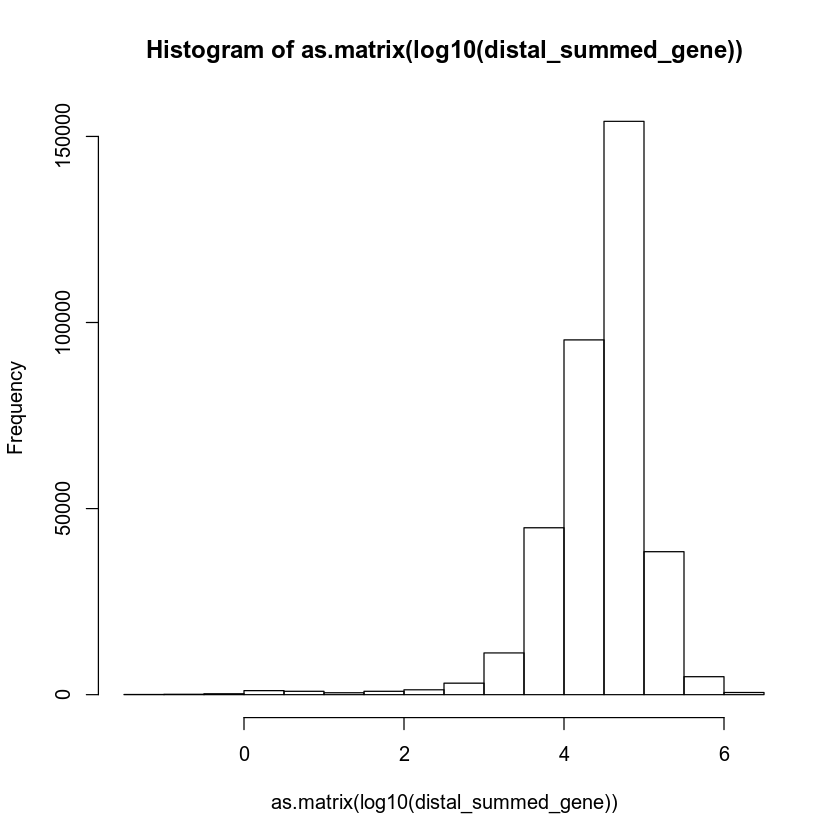

In [25]:
hist(as.matrix(log10(distal_summed_gene)))

In [29]:
common_genes = intersect(rownames(summed_gene), rownames(distal_summed_gene))
length(common_genes)

[1] 15867

In [ ]:
rowwise_cors = (sapply(seq.int(length(common_genes)), function(i) cor(unlist(summed_gene[common_genes[i],]), 
                                                                      unlist(distal_summed_gene[common_genes[i],]), 
                                                                      method="spearman")))

In [630]:
sum(is.na(rowwise_cors))
mean(rowwise_cors, na.rm=T)

[1] 445

[1] 0.8243179

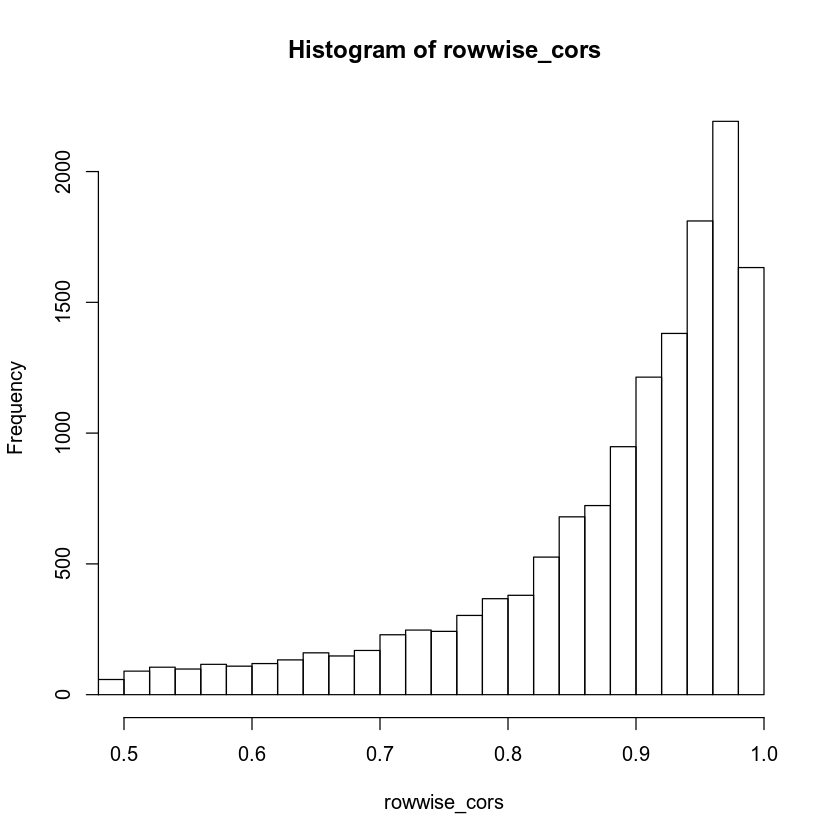

In [660]:
hist(rowwise_cors, xlim=c(0.5,1), breaks=100)

### Colouring the Graph


In [34]:
prom.hg38[prom.hg38$gene_name=="NKX2-2"]

GRanges object with 1 range and 3 metadata columns:
                  seqnames            ranges strand |   gene_name
                     <Rle>         <IRanges>  <Rle> | <character>
  ENSG00000125820       20 21514027-21516026      - |      NKX2-2
                          gene_id   gene_biotype
                      <character>    <character>
  ENSG00000125820 ENSG00000125820 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [743]:
GENE = "COL1A1"

In [744]:
summed_gene[GENE, ]

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
COL1A1,918.7501,561.3193,136.5422,159.4245,533.0423,965.7964,416.6573,518.2935,438.409,558.8788,557.9865,242.5881,180.0447,251.4299,103.4354,147.1364,743.4368,828.0247


In [745]:
distal_summed_gene[GENE, ]

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
COL1A1,94820.85,74614.72,43678.27,42569.67,69700.73,95307.21,61850.8,77549.86,64524.48,77285.27,68796.99,57207.2,50034.11,50986.1,40924.99,45712.42,87934.97,88637.76


In [746]:
max(summed_gene[GENE, ])/min(summed_gene[GENE, ])
max(distal_summed_gene[GENE, ])/min(distal_summed_gene[GENE, ])

[1] 9.337192

[1] 2.328826

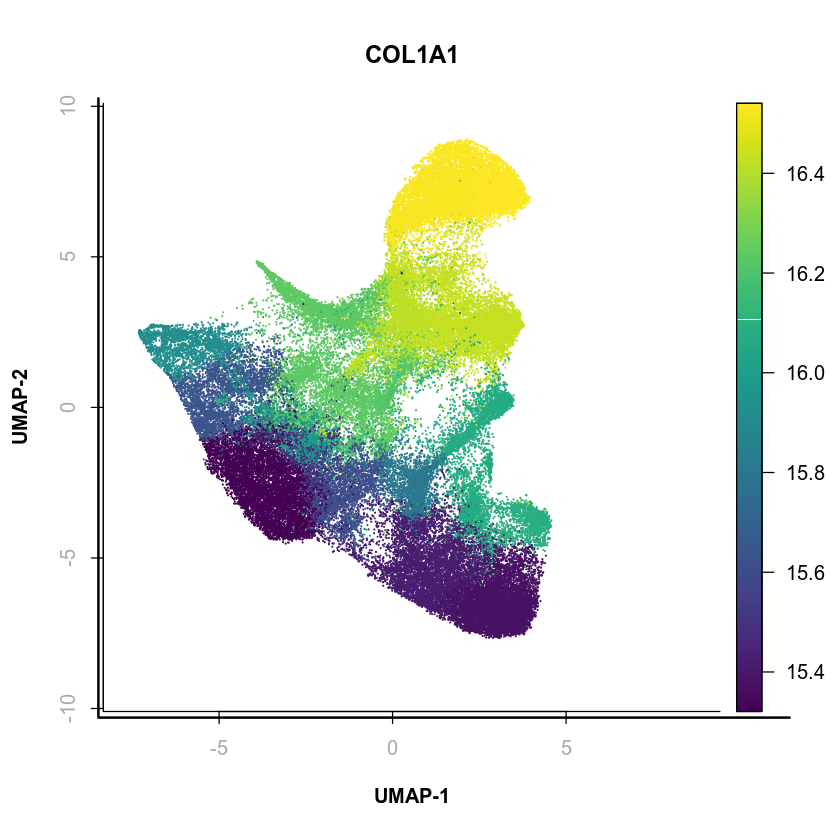

In [747]:
plotFeatureSingle(
    obj=x.sp,
    method="umap", 
    main=GENE,
    feature.value=log2(1+as.numeric(distal_summed_gene[GENE, ])[x.sp@cluster]), 
    point.size=0.1, 
    down.sample=NULL
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );

## Diff Genes

In [ ]:
library(edgeR)

In [154]:
data.use = distal_summed_gene
group = factor(seq(1,ncol(data.use)))
design = model.matrix(~group)
y = DGEList(counts=data.use, group=group)

In [155]:
# do pairwise comparisons and get union of top diff peaks
all_pairs = vector(mode = "list", length = ncol(data.use)*(ncol(data.use)-1)/2)
c = 1
for (i in seq(1,ncol(data.use))) {
    if (i < ncol(data.use)) {
        for (j in seq(i+1, ncol(data.use))) {
            all_pairs[[c]] = c(i,j)
            c = c+1
        }
    }
}

PER_PAIR = 2000

get_diff <- function(i, all_pairs, y, per_pair) {
    et = exactTest(y, dispersion = 0.4^2, pair = all_pairs[[i]])         
    cur_diff_peaks = rownames(et$table[order(et$table$PValue)[1:per_pair],])          
}

diff_genes_list = mclapply(seq(1, length(all_pairs)), 
                           get_diff, 
                           all_pairs=all_pairs, 
                           y=y,  
                           per_pair=PER_PAIR,
                           mc.cores=40)

In [156]:
diff_genes_set = unique(unlist(diff_genes_list))
length(diff_genes_set)

[1] 11807

## Plotting

In [157]:
library(ClusterR)
library(scales)
library(reshape2)
library(viridis)

In [704]:
to_cluster = as.matrix(data.use[diff_genes_set,])
to_cluster = to_cluster[rowSums(to_cluster)!=0,]
to_cluster = t(scale(t(log2(1+to_cluster))))[,]
# to_cluster = log2(1+distal_summed_gene)

dim(to_cluster)

[1] 11807    18

In [748]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(to_cluster, 
                        batch_size = 1000,
                        clusters=20,
                        num_init = 10, 
                        verbose = FALSE)

In [749]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


In [750]:
table(pr_mb)

pr_mb
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
 809  753  676  413  514  841  359  359  517  503  306   98  484  548 1381  546 
  17   18   19   20 
 874  530  615  681 

In [751]:
gene_clustered = to_cluster[order(pr_mb),]
head(gene_clustered, 2)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
PSORS1C1,3.762440,0.4365722,-0.1695075,-0.4409984,-0.2834516,-0.6908801,0.1629278,-0.1584038,-0.3600460,0.33254329,0.0205886,-0.6238193,0.05521932,-0.5837727,-0.1523655,-0.1145521,-0.8197962,-0.3726981
PTGFR,1.790126,0.2917627,-0.9962517,-1.0608616,-0.5241285,1.5048193,0.1565890,1.1286047,0.1994483,0.09009935,-0.5629456,-1.5557249,-1.03796780,-0.2996053,-0.8022540,-0.6185585,1.4117774,0.8850708


In [752]:
# order columns
col_distance = dist(t(gene_clustered))
col_cluster = hclust(col_distance, method="ward")
col_dendrogram = as.dendrogram(col_cluster)
colInd = rev(order.dendrogram(col_dendrogram))

gene_clustered_col_ordered = as.matrix(gene_clustered[, colInd])
head(gene_clustered_col_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


,cluster8,cluster5,cluster14,cluster7,cluster10,cluster9,cluster2,cluster12,cluster11,cluster15,cluster13,cluster16,cluster4,cluster3,cluster18,cluster17,cluster6,cluster1
PSORS1C1,-0.1584038,-0.2834516,-0.5837727,0.1629278,0.33254329,-0.3600460,0.4365722,-0.6238193,0.0205886,-0.1523655,0.05521932,-0.1145521,-0.4409984,-0.1695075,-0.3726981,-0.8197962,-0.6908801,3.762440
PTGFR,1.1286047,-0.5241285,-0.2996053,0.1565890,0.09009935,0.1994483,0.2917627,-1.5557249,-0.5629456,-0.8022540,-1.03796780,-0.6185585,-1.0608616,-0.9962517,0.8850708,1.4117774,1.5048193,1.790126


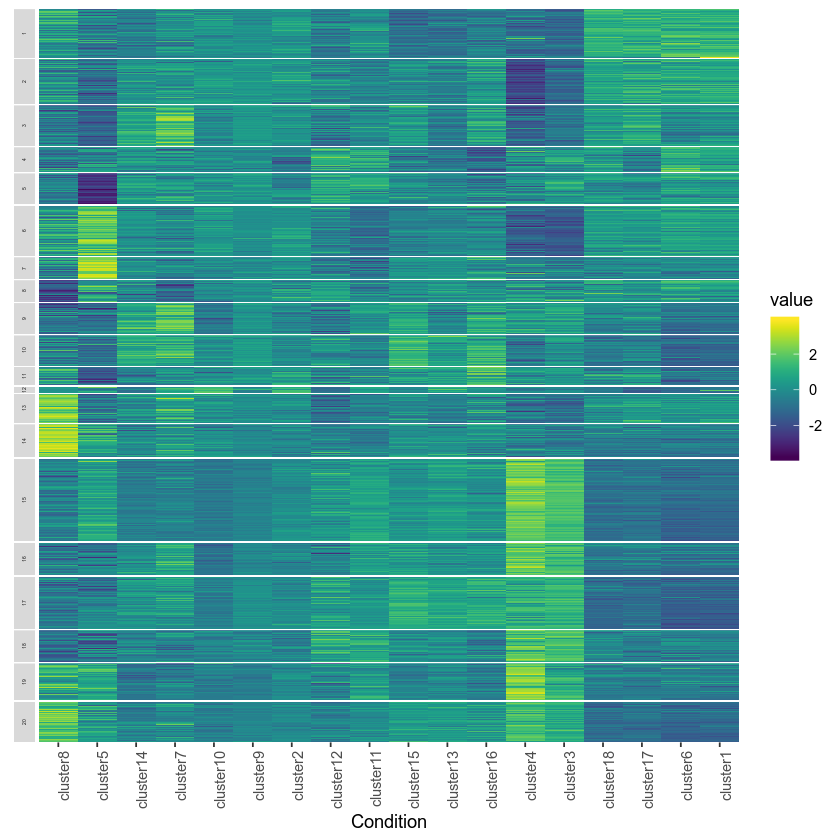

In [753]:
idxs = seq(1, nrow(gene_clustered_col_ordered), 1)
ggplot(data = melt(gene_clustered_col_ordered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-3, 3), oob=squish, option = "D") +
scale_fill_viridis(option="D") + 
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3))
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

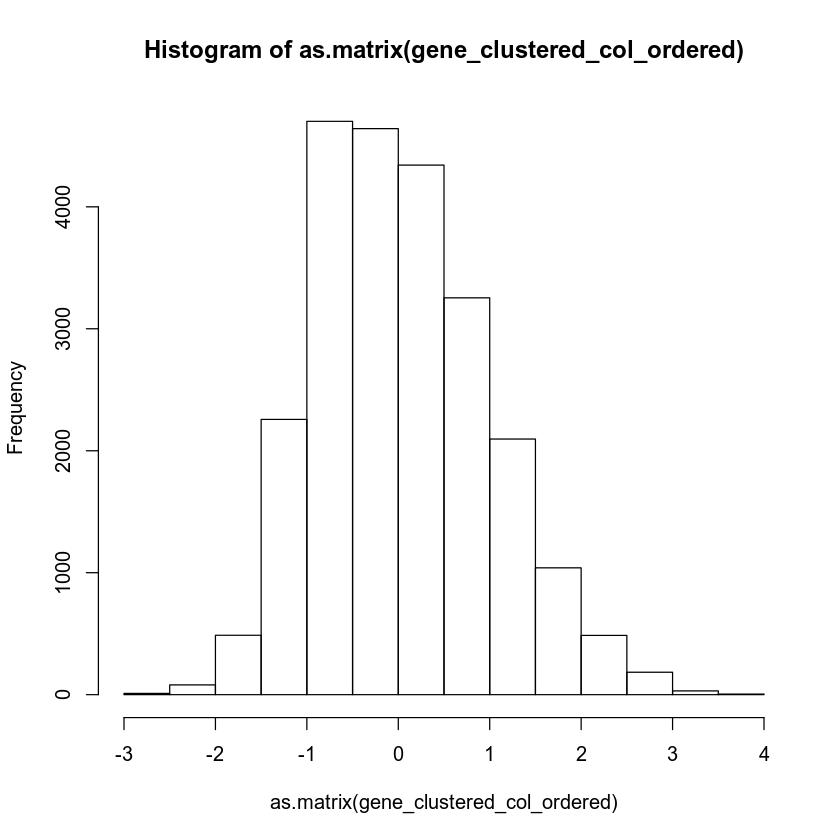

In [375]:
# See distribution of scores
hist(as.matrix(gene_clustered_col_ordered))

## Write Gene Lists for Clusters

In [376]:
CLUSTER_IDX = 1
NORM = 'temp'
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
LIST_PATH

[1] "gene_lists/20200202_temp_n5/idx1.txt"

In [377]:
for (i in seq(1,length(table(pr_mb)))){
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(LIST_PATH)
writeLines(rownames(to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [378]:
ALL_PEAKS_BED_PATH = sprintf("gene_lists/%s_%s_n%d/all_genes.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(to_cluster), fileConn)
close(fileConn)

[1] "gene_lists/20200202_temp_n5/all_genes.txt"
